In [7]:
import numpy as np
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2
import time
from numba import jit
from PIL import Image
import imageio

Show inputs


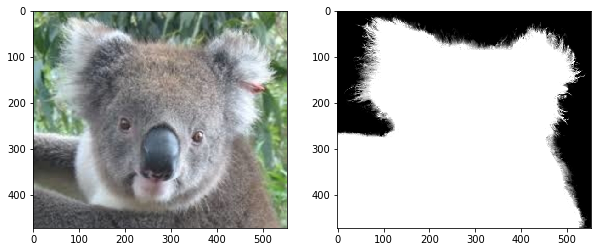

In [8]:
'''
Obtaining gray scale image from original image
'''

orig = imageio.imread('koala.jpg')
gray = imageio.imread('koala.jpg',as_gray='True')
tri = imageio.imread('koalaTrimap.bmp',as_gray = 'True')
h,w = gray.shape

print("Show inputs")
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.subplot(122)
plt.imshow(tri,cmap='gray')
plt.show()

Show fg and bg and mid


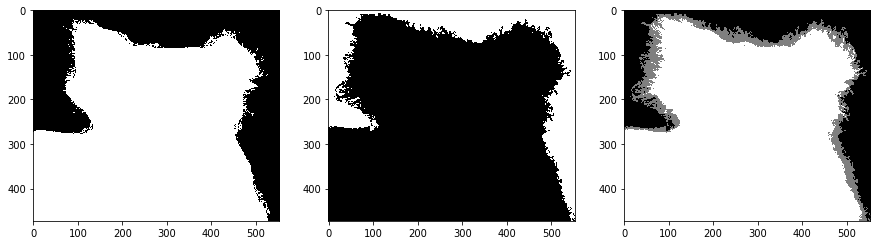

In [9]:
'''
Obtaining masks for fg(I=1 or 255), bg(I=0) and mid regions using trimap
'''

fg = tri == 255
bg = tri == 0
mid = np.zeros(tri.shape)
for i in range(mid.shape[0]):
    for j in range(mid.shape[1]):
        if(tri[i,j] != 0 and tri[i,j] != 255):
            mid[i,j] = 127
        if(tri[i,j] != 0 and tri[i,j] > 200):
            mid[i,j] = 255

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,cmap='gray')
plt.subplot(132)
plt.imshow(bg,cmap='gray')
plt.subplot(133)
plt.imshow(mid,cmap='gray')
plt.show()

We multiply the respective masks with the Gray image to get composite versions. The 'mid' image is a mask which shows the background pixels with intensity = 0, foreground with intensity = 1, and unknown pixels with intensity = 0.5.

Show fg and bg and mid


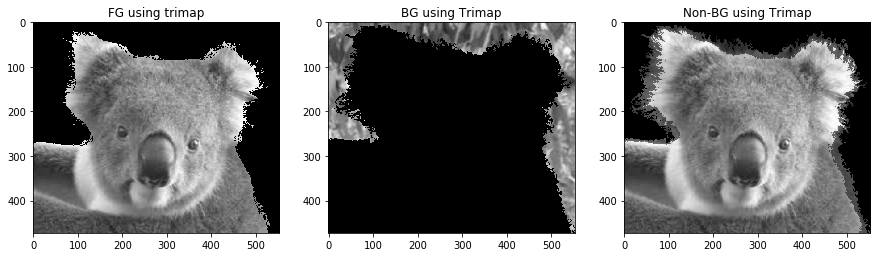

In [10]:
'''
Using masks, we obtain approximate foreground, background and non-background images using fg, bg and mid masks
'''

gray_fg = gray * fg
gray_bg = gray * bg
non_bg = gray * mid

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(gray_fg,cmap='gray')
plt.title("FG using trimap")
plt.subplot(132)
plt.imshow(gray_bg,cmap='gray')
plt.title("BG using Trimap")
plt.subplot(133)
plt.imshow(non_bg,cmap='gray')
plt.title("Non-BG using Trimap")
plt.show()

Generation of an estimate alpha matte 

First, the unknown region (not fg or bg) is found 

Then ,the pixels belonging to the unknown region is multiplied with an intensity of 0.5 and added to the fg to get an estimate alpha matte 

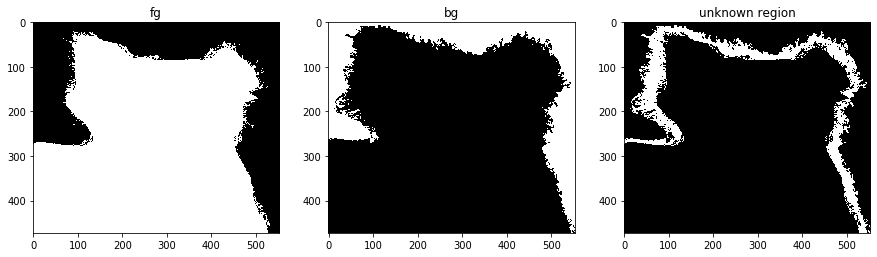

In [11]:
'''
Obtaining unknown region using the foreground and background masks 
'''

unknown = True ^ np.logical_or(fg,bg)

fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,'gray')
plt.title('fg')
plt.subplot(132)
plt.imshow(bg,'gray')
plt.title('bg')
plt.subplot(133)
plt.imshow(unknown,'gray')
plt.title('unknown region')
plt.show()


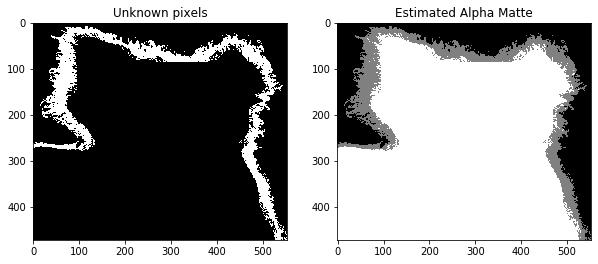

In [12]:
'''
Estimating Alpha matte using the masks for fg and unknown regions
'''

Estimate_alpha = fg + 0.5 * unknown

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(unknown,'gray')
plt.title('Unknown pixels')
plt.subplot(122)
plt.imshow(Estimate_alpha,'gray')
plt.title('Estimated Alpha Matte')
plt.show()

Generating Approximate Background and Foreground in the unknown region by checking the nearest neighbouring pixels

In [13]:
'''
Inpainting approximate fg and bg images
'''

not_fg = np.logical_not(fg)
bg_approx = cv2.inpaint(gray_bg.astype(np.uint8),(unknown + fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_fg
bg_approx = bg_approx.astype(np.float32)
not_bg = np.logical_not(bg)
fg_approx = cv2.inpaint(gray_fg.astype(np.uint8),(unknown + bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_bg
fg_approx = fg_approx.astype(np.float32)

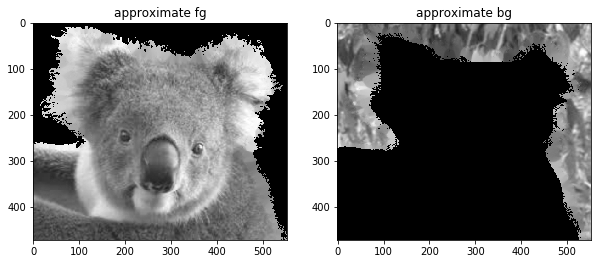

In [14]:
'''
Plotting approximate fg and bg
'''

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(fg_approx,'gray')
plt.title('approximate fg')
plt.subplot(122)
plt.imshow(bg_approx,'gray')
plt.title('approximate bg')
plt.show()

Using Poisson Equations, Reconstructing the Alpha matte

We use the gradient field of alpha matte to estimate the alpha matte

Finding the approximate matte gradient field

$$\Delta \alpha = div \frac{\nabla I}{F-B}$$

First, we find the approximate F-B 

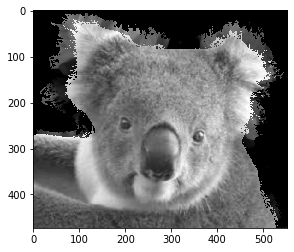

In [15]:
'''
Finding F-B using approximate fg and bg images
'''

diff_approx = fg_approx - bg_approx
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)

plt.imshow(diff_new, cmap='gray')
plt.show()


Modifying the approximate F-B

F-B where F and B are approximate foreground and background images


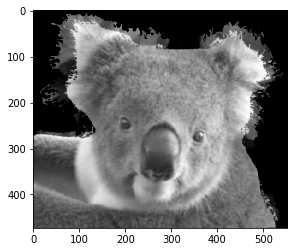

In [16]:
diff_approx = scipy.ndimage.filters.gaussian_filter(diff_approx, 0.9)
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)

print("F-B where F and B are approximate foreground and background images")
plt.imshow(diff_new, cmap='gray')
plt.show()

Then, we find the approximate gradient matte using the divergence operator

In [17]:
'''
Finding the gradient alpha matte 
'''

dy, dx = np.gradient(gray)
d2y, _ = np.gradient(dy/diff_approx)
_, d2x = np.gradient(dx/diff_approx)

b = d2y + d2x

Reconstructing alpha matte using the approximate gradient field(b) and Estimated alpha matte

We find the alpha matte by solving the laplacian

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ae5cade73b31dee0e04eb21b1e6e13b5944ef41)

We use the Gauss-Seidel iteration for this
![ig](https://wikimedia.org/api/rest_v1/media/math/render/svg/02f26444f4da61ae84a9824a6b5292949a483fcc)

In [18]:
def Alpha_matte_slow(alpha, b):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    
    iterations = 1
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    new_alpha[i,j] = 1/4  * (new_alpha[i-1 ,j] + new_alpha[i,j-1] + old_alpha[i, j+1] + old_alpha[i+1,j] - b[i,j])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha

In [19]:
New_alpha_slow = Alpha_matte_slow(Estimate_alpha, b)

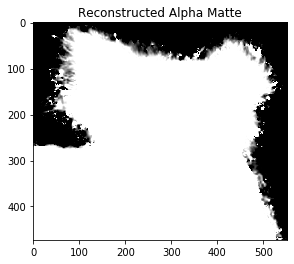

In [20]:
New_alpha_slow = np.maximum(New_alpha_slow,0)
New_alpha_slow = np.minimum(New_alpha_slow,1)
New_alpha_slow = New_alpha_slow.reshape(h,w)

plt.imshow(New_alpha_slow, cmap='gray')
plt.title("Reconstructed Alpha Matte")
plt.show()

# Using an optimised method to find Alpha matte 

In [21]:
def opt_Alpha_matte_jit(alpha,b, unknown_seg):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    non_zero = np.nonzero(unknown_seg)
    
    iterations = 1
    ca = np.transpose(non_zero)
    c = ca[(ca[:,0]>=1)&(ca[:,0]<h-1)&(ca[:,1]>=1)&(ca[:,1]<w-1)]
    c0 = c[:,0]
    c1 = c[:,1]
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        new_alpha[c0,c1] = 1/4  * (new_alpha[c0-1 ,c1] + new_alpha[c0,c1-1] + old_alpha[c0, c1+1] + old_alpha[c0+1,c1] - b[c0,c1])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha   

Comparing the time difference between optimised and slow version 

In [42]:
print('Time taken using previous method: ')
%timeit Alpha_matte_slow(Estimate_alpha, b)
print('Time taken using optimized method: ')
%timeit opt_Alpha_matte_jit(Estimate_alpha, b, unknown)

Time taken using previous method: 
3.59 s ± 62.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time taken using optimized method: 
121 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
New_alpha = opt_Alpha_matte_jit(Estimate_alpha, b,unknown)
New_alpha = np.maximum(New_alpha,0)
New_alpha = np.minimum(New_alpha,1)
New_alpha = New_alpha.reshape(h,w)

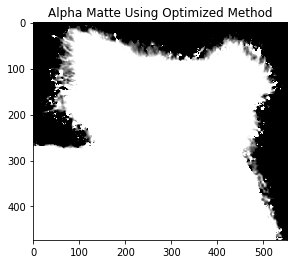

In [29]:
plt.imshow(New_alpha, cmap='gray')
plt.title("Alpha Matte Using Optimized Method")
plt.show()

## Generating final image using chroma-keying

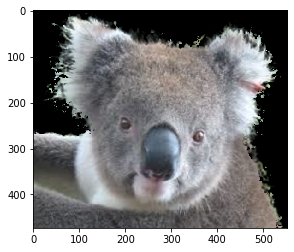

In [30]:
'''
Obtaining foreground image using the alpha matte found above
'''

new_fg = (New_alpha.reshape(h,w,1).repeat(3,2)*orig).astype(np.uint8)
plt.imshow(new_fg,cmap='gray')
bg = imageio.imread('grass.jpeg')
bg = np.asarray(bg)
res = np.zeros(new_fg.shape)

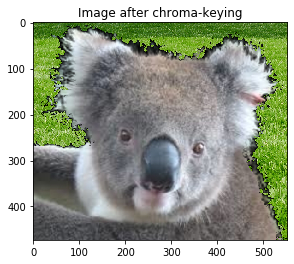

In [31]:
'''
Chroma Keying
'''

new_fg_arr = np.asarray(new_fg)
for i in range(new_fg.shape[0]):
    for j in range(new_fg.shape[1]):
        if(i<new_fg_arr.shape[0] and j<new_fg_arr.shape[1]):
            if(new_fg_arr[i,j,0] == 0 and new_fg_arr[i,j,1] == 0 and new_fg_arr[i,j,2] == 0):
                res[i,j,0] = bg[i,j,0]
                res[i,j,1] = bg[i,j,1]
                res[i,j,2] = bg[i,j,2]
            else:
                res[i,j,0] = new_fg_arr[i,j,0]
                res[i,j,1] = new_fg_arr[i,j,1]
                res[i,j,2] = new_fg_arr[i,j,2]
        else:
            res[i,j,0] = bg[i,j,0]
            res[i,j,1] = bg[i,j,1]
            res[i,j,2] = bg[i,j,2]
            
res = res.astype(np.uint8)
res_image = Image.fromarray(res)
plt.imshow(res)
plt.title('Image after chroma-keying')
plt.show()

# Generating Final Image using Alpha Blending

### I = α F + (1 − α )B

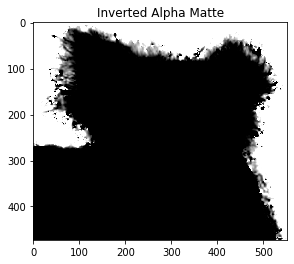

In [32]:
'''
Finding 1-alpha
'''

inverted_alpha = 1 - New_alpha

plt.imshow(inverted_alpha, cmap='gray')
plt.title("Inverted Alpha Matte")
plt.show()

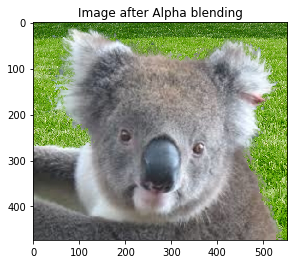

In [34]:
'''
Alpha Blending
'''

bg_new = imageio.imread('grass.jpeg')
bg_new = bg_new[0:h, 0:w, :]
final = np.zeros(bg_new.shape)

final[:, :, 0] = New_alpha * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final[:, :, 1] = New_alpha * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final[:, :, 2] = New_alpha * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

plt.imshow(final/255)
plt.title("Image after Alpha blending")
plt.show()

## Local Poisson Matting

In [35]:
new_local_matte = np.zeros_like(gray)

for i in range(0,h):
    for j in range(0,w):
        new_local_matte[i, j] = New_alpha[i,j]

In [36]:
def local_poisson_matte(starth, endh, startw, endw):
    local_matte = np.zeros((h,w))

    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)


    seg1 = gray[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]

    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx20)
    _, d2xfg = np.gradient(dxfg/diff_approx20)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx20)
    _, d2xbg = np.gradient(dxbg/diff_approx20)


    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx20)
    _, d2x = np.gradient(dx/diff_approx20)


    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = New_alpha[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg

    b_seg = d2y + d2x -(Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))


    matte = opt_Alpha_matte_jit(Estimate_alpha_seg, b_seg,unknown_seg)
    return matte

In [39]:
'''
Manually selecting regions and performing local poisson matting on them
'''

starth = 80
endh = 230
startw = 30
endw = 90
new_local_matte[starth:endh+1,startw:endw+1] = local_poisson_matte(starth, endh, startw, endw)
            
starth = 50
endh = 100
startw = 300
endw = 400
new_local_matte[starth:endh+1,startw:endw+1] = local_poisson_matte(starth, endh, startw, endw)

starth = 120
endh = 200
startw = 480
endw = 540
new_local_matte[starth:endh+1,startw:endw+1] = local_poisson_matte(starth, endh, startw, endw)


In [40]:
new_local_matte = np.maximum(new_local_matte,0)
new_local_matte = np.minimum(new_local_matte,1)
new_local_matte = new_local_matte.reshape(h,w)

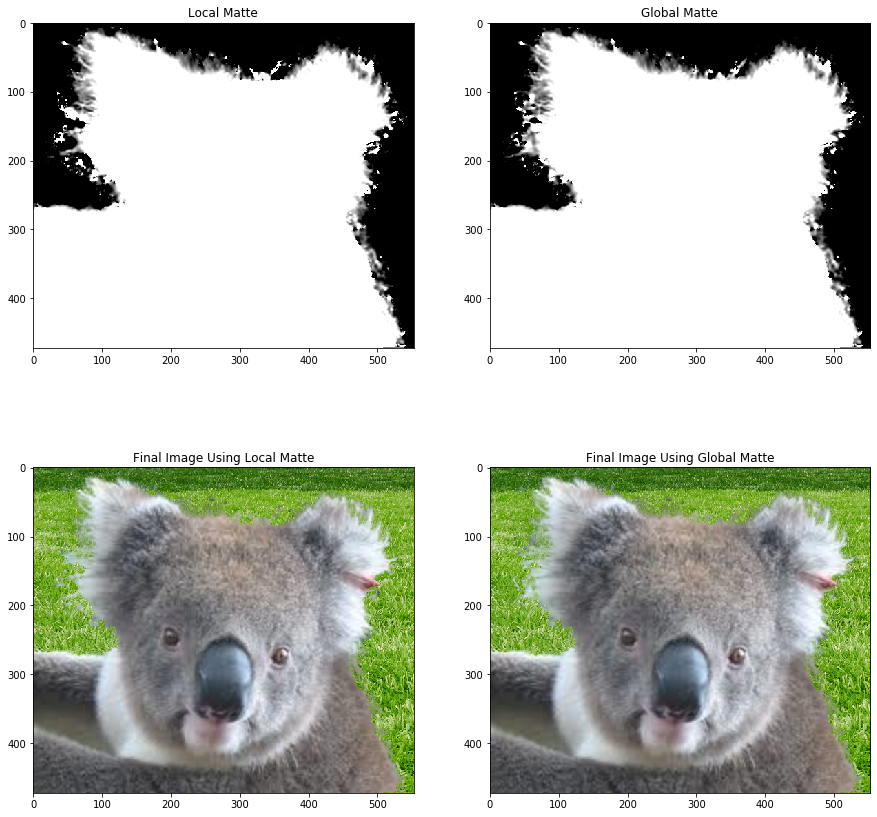

In [41]:
'''
Comparing Local Poisson Matting and Global Poisson Matting Results
'''

bg_new = imageio.imread('grass.jpeg')
bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alpha = 1 - new_local_matte

final_seg[:, :, 0] = new_local_matte * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final_seg[:, :, 1] = new_local_matte * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final_seg[:, :, 2] = new_local_matte * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(new_local_matte,cmap='gray')
plt.title("Local Matte")
plt.subplot(222)
plt.imshow(New_alpha,cmap='gray')
plt.title("Global Matte")
plt.subplot(223)
plt.imshow(final_seg/255)
plt.title("Final Image Using Local Matte")
plt.subplot(224)
plt.imshow(final/255)
plt.title("Final Image Using Global Matte")
plt.show()